In [43]:
# CARAR LIBRERIAS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix

In [2]:
# CARGAR BASE DE DATOS

df = pd.read_csv('../BBDD/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# BORRAR COLUMNA ID

df.drop(columns='id', inplace=True)

In [5]:
# COMPROBAR NANS Y PORCENTAJE

print(df.isnull().sum())
print('')
print(df.isnull().sum() / len(df) * 100)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


In [7]:
# TOTAL DE MISSINGS EN STROKE = 1

print(df[df['stroke'] == 1].count())
print(' ')
print(df[df['stroke'] == 1].isnull().sum())

gender               249
age                  249
hypertension         249
heart_disease        249
ever_married         249
work_type            249
Residence_type       249
avg_glucose_level    249
bmi                  209
smoking_status       249
stroke               249
dtype: int64
 
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  40
smoking_status        0
stroke                0
dtype: int64


In [8]:
# SUSTITUIR EN COLUMNA 'GENDER' FEMALE POR 0 Y MALE POR 1

df.loc[df['gender'] == 'Female', 'gender'] = 0
df.loc[df['gender'] == 'Male', 'gender'] = 1

# SUSTITUIR EN COLUMNA 'EVER_MARRIED' NO POR 0 Y YES POR 1

df.loc[df['ever_married'] == 'No', 'ever_married'] = 0
df.loc[df['ever_married'] == 'Yes', 'ever_married'] = 1

# SUSTITUIR EN COLUMNA 'RESIDENCE TYPE' RURAL POR 0 Y URBAN POR 1

df.loc[df['Residence_type'] == 'Rural', 'Residence_type'] = 0
df.loc[df['Residence_type'] == 'Urban', 'Residence_type'] = 1

In [9]:
# COMPROBAR CON UNA MASCARA SI HAY ALGUNA FILA CON GENDER 'OTHER'

df[df['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,0,Private,0,143.33,22.4,formerly smoked,0


In [10]:
# BORRAR FILA CON GENDER 'OTHER'

df.drop(index= 3116, inplace=True)

# RESETEAR LOS VALORES DEL INDICE

df.reset_index(drop = True, inplace = True)

In [11]:
# SEPARAR EN DISTINTAS COLUMNAS LAS DIFERENTES CATEGORIAS DE 'WORK TYPE' Y 'SMOKING STATUS'

df = pd.get_dummies(data=df, columns=['work_type', 'smoking_status'])

In [12]:
# CAMBIAR TIPOS EN COLUMNAS

df = df.astype({
    'gender': 'int64',
    'age': 'int64',
    'ever_married': 'int64',
    'Residence_type':'int64'
})

In [13]:
# RENOMBRAR COLUMNA RESIDENCE_TYPE

df.rename(columns={'Residence_type': 'residence_type'}, inplace=True)

In [14]:
# REORDENAR COLUMNAS

df = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'stroke']]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5109 non-null   int64  
 1   age                             5109 non-null   int64  
 2   hypertension                    5109 non-null   int64  
 3   heart_disease                   5109 non-null   int64  
 4   ever_married                    5109 non-null   int64  
 5   residence_type                  5109 non-null   int64  
 6   avg_glucose_level               5109 non-null   float64
 7   bmi                             4908 non-null   float64
 8   work_type_Govt_job              5109 non-null   uint8  
 9   work_type_Never_worked          5109 non-null   uint8  
 10  work_type_Private               5109 non-null   uint8  
 11  work_type_Self-employed         5109 non-null   uint8  
 12  work_type_children              51

In [16]:
# DIVIDIR EN TRAIN Y TEST

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# IMPUTAR MISSINGS MEDIANTE KNN

imputer = KNNImputer(n_neighbors=5)

imputer.fit(X_train[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

X_train[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']] = imputer.transform(X_train[['gender', 'age', 'hypertension',                'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

In [18]:
# COMPROBAR QUE NO HAY MISSINGS

X_train.isnull().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
residence_type                    0
avg_glucose_level                 0
bmi                               0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [19]:
# BALANCEAR TARGET CON SMOTE

from collections import Counter

counter = Counter(y_train)
print('Antes de SMOTE', counter)

smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_smt)
print('Despues de SMOTE', counter)

Antes de SMOTE Counter({0: 3900, 1: 187})
Despues de SMOTE Counter({0: 3900, 1: 3900})


# TEST

In [29]:
# IMPUTAR MISSINGS MEDIANTE KNN

imputer = KNNImputer(n_neighbors=5)

imputer.fit(X_test[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

X_test[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']] = imputer.transform(X_test[['gender', 'age', 'hypertension',                'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

# MODELOS

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [38]:
results = pd.DataFrame(columns = ['SVC', 'LR', 'RF', 'XGB'], index = range(4))

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       960
           1       0.16      0.71      0.26        62

    accuracy                           0.76      1022
   macro avg       0.57      0.74      0.56      1022
weighted avg       0.93      0.76      0.82      1022

ROC AUC score: 0.832

-----------------------------------------------------

Cross-validation scores with 10 folds:

ROC AUC: 0.95
precision: 0.79
recall: 0.9
f1: 0.84


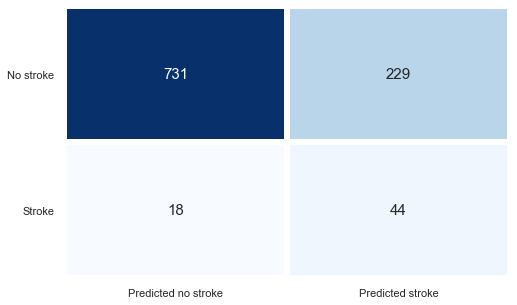

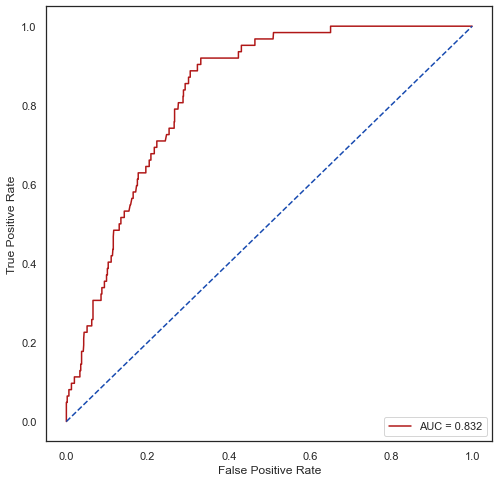

In [41]:
# RANDOM FOREST

rf = RandomForestClassifier(random_state=42, max_depth=3)
rf.fit(X_train_smt, y_train_smt)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 3] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 3] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 3] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 3] = round(roc_auc_score(y_test, y_prob), 3)
rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 10 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(rf, X_train_smt, y_train_smt, cv = 10, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(rf, X_train_smt, y_train_smt, cv = 10, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(rf, X_train_smt, y_train_smt, cv = 10, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(rf, X_train_smt, y_train_smt, cv = 10, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()